# timeseries query

An Query defines a multivariate time series query on the Waylay timeseries database, and can be stored under a name as a Query Configuration.

These Query Configurations can be authored and tested on the console https://console.waylay.io/analytics/queries and be saved name. 

The `analtyics.query` resource in the Waylay Python SDK uses the analytics backend REST services to read, create, update, delete and execute Query Configuration using a standardised JSON representation. 

A JSON definition of Query can also be executed without storing in a Configuration.

See https://docs.waylay.io/api/query/ or https://docs-io.waylay.io/#/features/query/ for more documentation.

## example usage
Import the client and check your backend connections

In [1]:
from waylay import WaylayClient
waylay_client = WaylayClient.from_profile()

In [2]:
waylay_client.analytics.about.version()

'tsanalytics.server 0.20.3+1.gdf522f4'

... assuming you have previously saved a query under the `151CF-temperature` temperature name ...

`waylay_client.analytics.query.get` fetches the query _definition_.

In [3]:
q_151CF_temp = waylay_client.analytics.query.get('151CF-temperature')
q_151CF_temp

{'data': [{'resource': '151CF', 'aggregation': 'median'},
  {'metric': 'avgSnr', 'resource': '151CF'},
  {'metric': 'lightAmbi', 'aggregation': 'median'},
  {'metric': 'avgSnr', 'resource': '151D8'}],
 'freq': 'P1D',
 'metric': 'temperature',
 'window': 'P2M',
 'resource': '151CF',
 'aggregation': 'median',
 'interpolation': {'method': 'pad'}}

By default, only the query definition is returned. If you want all metadata, use the `raw` parameter


In [4]:
waylay_client.analytics.query.get('151CF-temperature', raw=True).body

{'messages': [],
 'name': '151CF-temperature',
 'query': {'data': [{'resource': '151CF', 'aggregation': 'median'},
   {'metric': 'avgSnr', 'resource': '151CF'},
   {'metric': 'lightAmbi', 'aggregation': 'median'},
   {'metric': 'avgSnr', 'resource': '151D8'}],
  'freq': 'P1D',
  'metric': 'temperature',
  'window': 'P2M',
  'resource': '151CF',
  'aggregation': 'median',
  'interpolation': {'method': 'pad'}},
 'meta': {'name': 'temperature',
  'tags': ['imported'],
  '_links': {'source': 'https://ts-analytics-staging.waylay.io/config/151CF/temperature'},
  'author': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
  'source': "/resources/151CF#tsa_2/configs/*[name='temperature']",
  'modified': '2019-10-16T13:51:22.991765+00:00',
  'resource': '151CF'},
 'attrs': {'created': '2019-10-16T13:51:22.991765+00:00',
  'created_by': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
  'modified': '2020-08-25T11:53:21.406523+00:00',
  'modified_by': 'users/0476f99d-ac60-4f86-bc45-7215962754cd'},
 '_li

To execute the saved query, use the `data` operation.

By default, this returns a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), which render nicely in jupyter notebooks and have built-in support for plots.

In [5]:
df_now = waylay_client.analytics.query.data('151CF-temperature', params={"from":"-P200D"}, timeout=2000)
df_now.head(5)

resource                        151CF                   151D8
metric                    temperature avgSnr lightAmbi avgSnr
aggregation                    median median    median median
timestamp                                                    
2021-04-04 00:00:00+00:00         NaN   None       NaN   None
2021-04-05 00:00:00+00:00         NaN   None       NaN   None
2021-04-06 00:00:00+00:00         NaN   None       NaN   None
2021-04-07 00:00:00+00:00         NaN   None       NaN   None
2021-04-08 00:00:00+00:00         NaN   None       NaN   None

<AxesSubplot:xlabel='timestamp'>

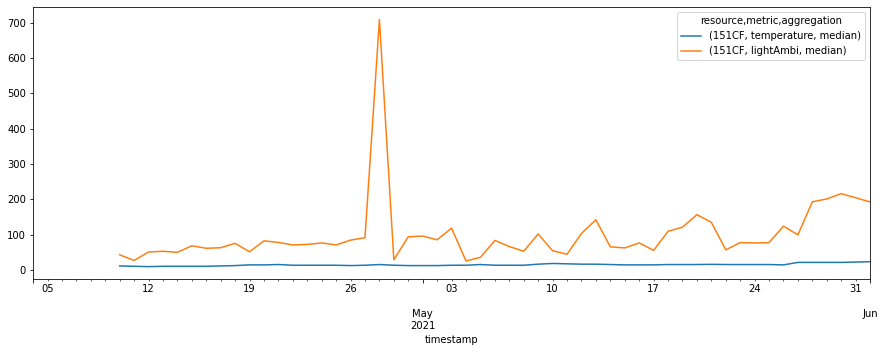

In [6]:
df_now.plot(figsize=(15,5))

You can override parameters of the query definition in a `params` argument.

In [15]:
df_100_days_ago = waylay_client.analytics.query.data('151CF-temperature', params={
    'window': 'P100D','until':'-P100D'
})
df_100_days_ago.describe()

resource          151CF            
metric      temperature   lightAmbi
aggregation      median      median
count         94.000000   94.000000
mean          18.526596  100.680851
std            4.627156   83.346145
min           10.000000   26.000000
25%           14.250000   52.375000
50%           19.000000   77.000000
75%           22.000000  131.625000
max           28.000000  709.000000

<AxesSubplot:xlabel='timestamp'>

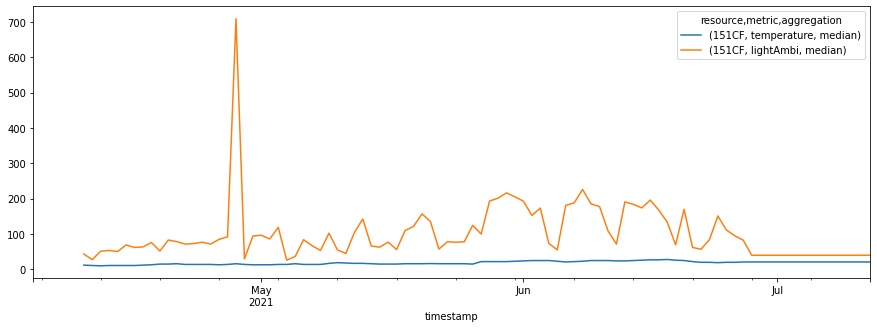

In [16]:
df_100_days_ago.plot(figsize=(15,5))

You can suppress the conversion to dataframes by setting `response_constructor=False`.

In [18]:
waylay_client.analytics.query.data(
    '151CF-temperature',
    params={'until':'2021-02-01', 'window':'P5D'},
    response_constructor=False
)

[{'columns': ['timestamp',
   {'resource': '151CF', 'metric': 'temperature', 'aggregation': 'median'},
   {'resource': '151CF', 'metric': 'avgSnr', 'aggregation': 'median'},
   {'resource': '151CF', 'metric': 'lightAmbi', 'aggregation': 'median'},
   {'resource': '151D8', 'metric': 'avgSnr', 'aggregation': 'median'}],
  'data': [[1611705600000, 20, None, 2, None],
   [1611792000000, 20, None, 2, None],
   [1611878400000, 19, None, 2, None],
   [1611964800000, 18, None, 2, None],
   [1612051200000, 19, None, 2, None]],
  'data_axis': 'column',
  'attributes': {'role': 'input'},
  'window_spec': {'from': 1611705600000,
   'until': 1612137600000,
   'window': 'P5D',
   'freq': 'P1D'}}]

You can build your own query config definitions, store them `analytics.query.create`, and execute them.

In [19]:
new_query_cfg_name = '151CF-temperature-demo'
new_query_cfg = { 
    'name': new_query_cfg_name,
    'query': {},
    'meta': { 'description': 'demo, modified version of 151CF-temperature'}
}
new_query = dict(q_151CF_temp)
new_query_cfg['query'] = new_query
new_query['data'] = [ series for series in new_query['data'] if (series.get('metric') != 'lightAmbi') ]
new_query['until'] = '2021-02-01'
new_query['window'] = 'P30D'
new_query_cfg

{'name': '151CF-temperature-demo',
 'query': {'data': [{'resource': '151CF', 'aggregation': 'median'},
   {'metric': 'avgSnr', 'resource': '151CF'},
   {'metric': 'avgSnr', 'resource': '151D8'}],
  'freq': 'P1D',
  'metric': 'temperature',
  'window': 'P30D',
  'resource': '151CF',
  'aggregation': 'median',
  'interpolation': {'method': 'pad'},
  'until': '2021-02-01'},
 'meta': {'description': 'demo, modified version of 151CF-temperature'}}

We first delete any existing query config under that name

In [20]:
### need to delete any existing query config first
from waylay import RestResponseError
try: 
    waylay_client.analytics.query.remove(new_query_cfg_name)
    print(f"'{new_query_cfg_name}' deleted")
except RestResponseError as exc:
    print(exc)

'151CF-temperature-demo' deleted


In [21]:
waylay_client.analytics.query.create(body=new_query_cfg)

{'data': [{'resource': '151CF', 'aggregation': 'median'},
  {'metric': 'avgSnr', 'resource': '151CF'},
  {'metric': 'avgSnr', 'resource': '151D8'}],
 'freq': 'P1D',
 'until': '2021-02-01',
 'metric': 'temperature',
 'window': 'P30D',
 'resource': '151CF',
 'aggregation': 'median',
 'interpolation': {'method': 'pad'}}

<AxesSubplot:xlabel='timestamp'>

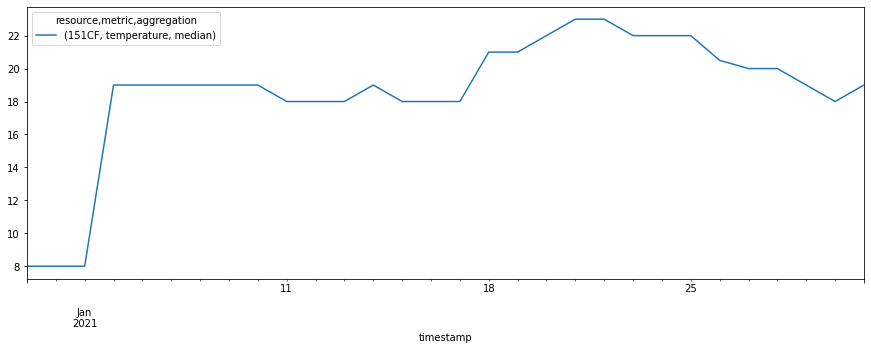

In [22]:
waylay_client.analytics.query.data(new_query_cfg_name).plot(figsize=(15,5))

a query config can be updated (the representation cannot have a name in it then)

<AxesSubplot:xlabel='timestamp'>

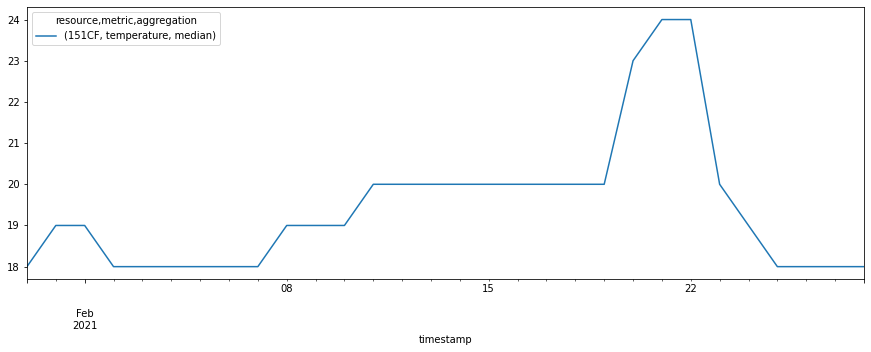

In [23]:
new_query['until'] = '2021-03-01'
waylay_client.analytics.query.replace('151CF-temperature-demo', body={'query': new_query})
waylay_client.analytics.query.data('151CF-temperature-demo').plot(figsize=(15,5))

If a query does not need to be stored, you can use  `analytics.query.execute` to execute a query without saving it as a Query Configuration

In [26]:
waylay_client.analytics.query.execute(body=new_query, params={'window':'P5D'})

resource                        151CF         151D8
metric                    temperature avgSnr avgSnr
aggregation                    median median median
timestamp                                          
2021-02-24 00:00:00+00:00          19   None   None
2021-02-25 00:00:00+00:00          18   None   None
2021-02-26 00:00:00+00:00          18   None   None
2021-02-27 00:00:00+00:00          18   None   None
2021-02-28 00:00:00+00:00          18   None   None